In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


# Utility Functions

In [63]:
def load_pkl(path):
    return pickle.load(open(path, "rb"))

In [70]:
def load_data(data):
    keys = ['message_seqs', 'encoded_seqs', 'noisy_seqs', 'viterbi_decoded_seqs']
    x = data[keys[2]] # noisy sequences will be our input to our models
    y = data[keys[0]]
    y_viterbi_decoded = data[keys[3]]
    
    x = np.array(x)
    y = np.array(y)
    y_viterbi_decoded = np.array(y_viterbi_decoded)
    
    return x, y, y_viterbi_decoded

In [71]:
def load(path):
    return load_data(load_pkl(path))

In [170]:
def load_pkl_paths_from_folder(dir_path):
    return [dir_path + "/" + x for x in os.listdir(dir_path) if ".pkl" in x ]

# Data Processing

In [51]:
def train_test_split(x, y, test_ratio=0.2):
    indicies = np.arange(len(x))
    np.random.shuffle(indicies)
    
    split_inx = int(len(X) * (1-test_ratio))
    X_train, X_test = X[indicies[:split_inx]], X[indicies[split_inx:]]
    y_train, y_test = y[indicies[:split_inx]], y[indicies[split_inx:]]
    
    return X_train, X_test, y_train, y_test

# Model Definitions

Optimizers

In [33]:
optimizers = {
    "adam": Adam, 
    "sgd":  SGD
}

Fully Connected Neural Net

In [43]:
default_fnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "l2_strength": 0.01,
    "learing_rate": 0.015,
    "optimizer": "adam",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

In [35]:
default_fnn_architecture = [32,64, 100]

Convolution 1D Nerual Net

In [44]:
default_cnn_param = {
    "batch_size": 64,
    "epoch": 25,
    "verbose": 2,
    "validation_ratio": 0.2,
    "activation": "relu",
    "dropout_keep_prob": 0.5,
    "learing_rate": 0.01,
    "optimizer": "adam",
    "conv_padding": "same",
    "metrics": ["accuracy"],
    "loss_fn": "binary_crossentropy"
}

Avaliable Layers:

Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D

In [47]:
default_cnn_architecture = [
    "conv1d"
]

# Model Construction

In [52]:
def build_fnn(input_shape, 
              output_shape=(-1,2), 
              architecture=default_fnn_architecture, 
              param=default_fnn_param):
    """
    Train a FNN model with INPUT_SHAPE and OUTPUT_SHAPE using ARCHITECTURE and PARAM.
    """

    model = Sequential()
    
    for i, output_units in enumerate(architecture):
        if i == 0:
            model.add(Dense(output_units, activation=param["activation"],
                        input_shape=input_shape,
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
        else:
            model.add(Dense(output_units, activation=param["activation"],
                        kernel_regularizer=regularizers.l2(param["l2_strength"])))
    
    model.add(Dense(np.product(output_shape), activation="sigmoid"))
    model.add(Reshape(output_shape))
    
    opt = optimizers[param["optimizer"]](lr=param["learing_rate"])
    model.compile(optimizer=opt, loss=param["loss_fn"], metrics=param["metrics"])
    ""
    return model

In [49]:
def train_fnn(model, x, y, param=default_fnn_param, shuffle=True):
    model.fit(x, y, batch_size=param["batch_size"], epochs=param["epoch"], shuffle=shuffle,
              verbose=param["verbose"], validation_split=param["validation_ratio"])
    return model

# Evaluation Metrics

In [130]:
def accuracy(y, y_pred, argmax=False, viterbi=False):
    y_pred_binary = y_pred
    
    if viterbi:
        y_pred_binary = [p[:y.shape[1]] for p in y]
    elif argmax:
        y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
        assert y.shape == y_pred_binary.shape, "prediction and ground truth must have same shape"
    
    return np.sum(y == y_pred_binary) / np.product(y.shape)

In [131]:
def model_accuracy(model, x, y, argmax=False):
    if argmax:
        y_pred = model.predict(x)
        return accuracy(y, y_pred, argmax)
    else:
        return model.evaluate(x, y, verbose=0)

# Experiments

Accuracy of viterbi decoding over vs. message length K

In [173]:
accuracies = list()
plt_range = list()
for pkl in load_pkl_paths_from_folder("../data/dataset_02/exp_k/"):
    x, y, y_viterbi_decoded = load(pkl)
    acc = accuracy(y, y_viterbi_decoded, viterbi=True)
    accuracies.append(acc)
    plt_range.append(int(pkl.split("data_n5000_k")[1].split("_")[0]))

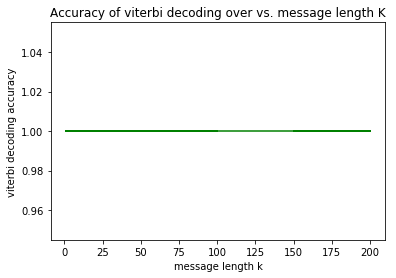

In [175]:
plt.title("Accuracy of viterbi decoding over vs. message length K")
plt.xlabel("message length k")
plt.ylabel("viterbi decoding accuracy")
plt.plot(plt_range, accuracies, "g-")